In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 14b : Lecture
## Working with PyTorch
- one hidden layer 
- ${tanh}$ activation function
- multi-class output
- FIFA dataset 

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
import os

#import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

#--------------------------------------
import torch

import torch.nn as nn

import torch.nn.functional as F

from torch.autograd import Variable

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 4001 # number of epochs
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.Spectral

plt.rcParams.update(params)

## Read FIFA 2019 data set

In [4]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [5]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [7]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [8]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [9]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [11]:
y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

# one hot encoding
y = pd.get_dummies(y).values
X.shape, y.shape

((18147, 33), (18147, 4))

In [12]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517, 4) (3630, 33) (3630, 4)


In [13]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [14]:
torch.cuda.is_available()

True

In [15]:
torch.version.cuda

'11.3'

In [16]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
device

'cuda'

In [19]:
class Model ( nn.Module ):
    
    def __init__ (self, input_dim):
        
        super( Model, self).__init__()
        
        self.layer1 = nn.Linear( input_dim, 18)
        
        self.layer2 = nn.Linear( 18, 4)
        
    def forward(self, x):
        
        x = F.silu (  self.layer1 ( x ) ) # Layer 1 activations

        x = F.softmax (  self.layer2 ( x ) , dim = 1) # Layer 2 activations
    
        return x

In [20]:
model  = Model( X_train.shape[1] ).to(device)

print(model)

Model(
  (layer1): Linear(in_features=33, out_features=18, bias=True)
  (layer2): Linear(in_features=18, out_features=4, bias=True)
)


In [21]:
list(model.parameters())

[Parameter containing:
 tensor([[ 9.2062e-02, -4.3501e-02, -1.4794e-01,  1.0717e-02,  1.6225e-01,
          -7.7643e-02, -5.6670e-02,  1.3613e-01, -2.4222e-02, -6.6486e-02,
          -3.5062e-02,  6.3746e-03, -1.4182e-01, -4.9749e-02,  1.6879e-01,
          -3.7317e-02,  1.5855e-01, -6.7960e-02, -7.0020e-02, -5.1887e-02,
          -1.5565e-01, -1.0485e-01,  1.0520e-01, -1.3059e-01,  5.9465e-02,
           1.6379e-01, -2.2121e-02,  7.6153e-02,  8.1313e-02, -1.2426e-01,
          -6.7123e-02, -5.4516e-02,  1.6798e-01],
         [-1.5537e-01,  1.0537e-01,  1.6350e-01,  1.3764e-01,  7.4190e-02,
           7.7494e-02, -9.2818e-03,  8.7583e-02,  1.5868e-01, -5.5976e-02,
           1.6820e-01,  2.7665e-02, -1.2210e-01, -1.2494e-01,  6.1399e-02,
          -2.4561e-02, -7.6685e-02,  8.8150e-02, -9.1821e-02, -8.3203e-02,
           3.2539e-02, -3.1431e-02, -1.4688e-01, -5.2295e-02, -6.1178e-02,
          -7.4187e-02,  1.3552e-01, -2.6404e-02, -1.0632e-01,  5.1576e-02,
           2.9993e-02, -1.3

In [22]:
train_X = Variable( torch.Tensor(X_train).float() ).to(device)
train_y = Variable( torch.Tensor(y_train) ).to(device)

test_X = Variable( torch.Tensor(X_test) ).to(device)
test_y = Variable( torch.Tensor(y_test) ).to(device)


In [25]:
loss_fn = nn.CrossEntropyLoss()


loss = []

tloss = []

n_epoch = []

acc = []

tacc = []


optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)


for epoch in range (EPOCHS):
    
    model.train() # Set the model in training mode
    
    y_pred_tr = model(train_X)
    
    curr_loss = loss_fn(y_pred_tr, train_y)
    
    # Back prop
    optimizer.zero_grad()
    
    curr_loss.backward()
    
    optimizer.step()
    #----------------------------------------------
    if epoch % 2 == 0:
        
        loss.append ( curr_loss.data.item() )
        
        predictions = model(train_X)
        
        _, y_pred = torch.max(predictions, 1)
        
        curr_acc = accuracy_score( y_train.argmax(axis = 1), y_pred.data.cpu())
        
        acc.append(curr_acc)
        
        model.eval() # evaluation mode
        
        y_pred_tst = model(test_X)
        
        tcurr_loss = loss_fn( y_pred_tst, test_y)
        
        predictions = model(test_X)
        
        _, y_pred = torch.max(predictions, 1)
        
        tcurr_acc = accuracy_score( y_test.argmax(axis = 1), y_pred.data.cpu())
        
        tacc.append(tcurr_acc)
        
        tloss.append( tcurr_loss.data.item())
        
        n_epoch.append(epoch)
        
        
    if epoch % 100 == 0:
        fmtStr = 'Epoch : {:5d}/{:5d} --- Loss: {:.5f} | Test Loss {:.5f} | Acc {:.5f} test Acc {:.5f}'
        
        print (fmtStr.format(epoch, EPOCHS,
                             curr_loss.data.item(),
                             tcurr_loss.data.item(),  
                             curr_acc, 
                             tcurr_acc))

Epoch :     0/ 4001 --- Loss: 1.37463 | Test Loss 1.37001 | Acc 0.33333 test Acc 0.33994
Epoch :   100/ 4001 --- Loss: 1.06746 | Test Loss 1.05896 | Acc 0.77158 test Acc 0.77906
Epoch :   200/ 4001 --- Loss: 0.95138 | Test Loss 0.94383 | Acc 0.81022 test Acc 0.81928
Epoch :   300/ 4001 --- Loss: 0.92108 | Test Loss 0.91440 | Acc 0.83454 test Acc 0.84132
Epoch :   400/ 4001 --- Loss: 0.90173 | Test Loss 0.89659 | Acc 0.85066 test Acc 0.85510
Epoch :   500/ 4001 --- Loss: 0.88954 | Test Loss 0.88504 | Acc 0.86099 test Acc 0.86667
Epoch :   600/ 4001 --- Loss: 0.88267 | Test Loss 0.87854 | Acc 0.86753 test Acc 0.86970
Epoch :   700/ 4001 --- Loss: 0.87835 | Test Loss 0.87457 | Acc 0.87050 test Acc 0.87273
Epoch :   800/ 4001 --- Loss: 0.87525 | Test Loss 0.87179 | Acc 0.87284 test Acc 0.87548
Epoch :   900/ 4001 --- Loss: 0.87282 | Test Loss 0.86964 | Acc 0.87373 test Acc 0.87686
Epoch :  1000/ 4001 --- Loss: 0.87076 | Test Loss 0.86785 | Acc 0.87532 test Acc 0.87631
Epoch :  1100/ 4001 -

In [26]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

In [28]:
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.374635,1.370011,0.333333,0.339945
1,2,1.367202,1.362320,0.429359,0.439118
2,4,1.359587,1.354455,0.486257,0.485950
3,6,1.351817,1.346443,0.507336,0.505234
4,8,1.343921,1.338319,0.526624,0.525895


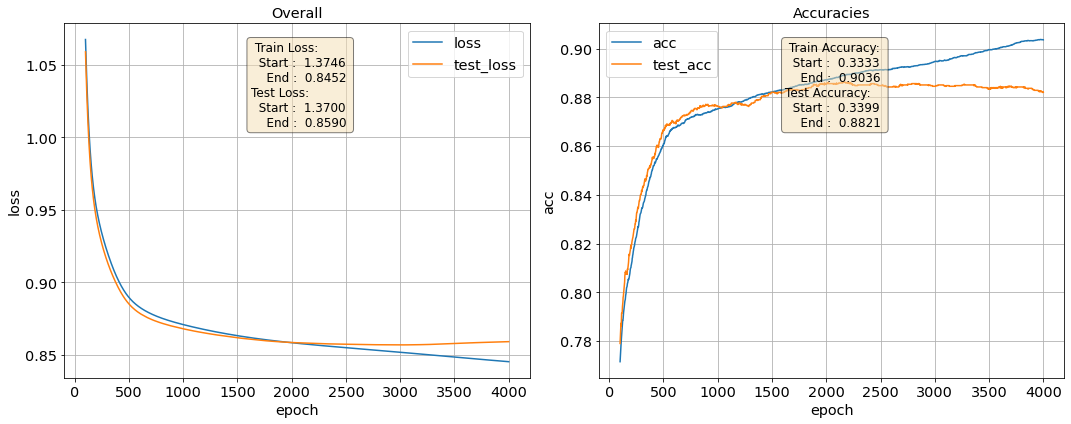

In [32]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 50 # ignoring first few records
x_var = 'epoch'
y1_var = 'loss'
y2_var = 'test_loss'

ax = axes[0]

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'acc'
y2_var = 'test_acc'

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()

In [30]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
1491,2982,0.851784,0.856741,0.8944,0.884573
